# Preprocesamiento
## Recomendaciones/Requerimientos
* ### Muestra del 20% de los datos
* ### Considerar únicamente la lista corta de causas de muerte (lc1)
* ### Eliminar:
* * ### Defunciones ocurridas fuera de Ecuador
* * ### Muertes violentas
* * ### Muertes por COVID-19
* * ### Causas mal definidas
* * ### Resto de causas
* * ### Valores vacíos
* ### Crear una fecha de almacenamiento que considere año y mes (variable categórica)
* ### Seleccionar las variables del dataset

Antes de preprocesar el dataset como tal, se analizan los datos con un software externo y consultando el documento de la metodología del Registro
Estadístico de Defunciones Generales del INEC, para comprender la información con la que se está trabajando y comenzar a eliminar información innecesaria o inválida

Se comenzará por la lista de consideraciones y eliminaciones del archivo completo

In [ ]:
%pip install pandas pyreadstat

In [ ]:
# Bibliotecas
import pandas as pd
import numpy as np

Se carga y se muestra todo el archivo .sav

In [ ]:
df = pd.read_spss('EDG_1990_2021.sav')
df

La primer consideración en la lista del principio es considerar solo la lista lc1, adicionalmente, considerar solo las muertes por causas naturales.
La lista lc1 se refiere a la **lista reducida de causas de muerte CIE-10**

Se comenzará eliminando todos los datos que no contengan información alguna en la columna lc1

In [ ]:
#Se crea nuevo dataset para almacenar los preprocesamientos
df_1 = df.dropna(subset=['lc1'])
df_1

#df.dropna(subset=['lc1'])

Las eliminaciones de muertes violentas, por COVID-19, por causas mal definidas y por el resto de causas pueden eliminarse al mismo tiempo

Sus valores lc1 son 64, 66 y 67 (COVID), 99 y 88 respectivamente

In [ ]:
lc1_del = ['64 Agresiones (Homicidios)', 'COVID-19, virus identificado', 'COVID-19, virus no identificado', '99 Causas mal definidas', '88 Resto de causas'] #Lista de valores lc1 a eliminar
df_1 = df_1[~df_1['lc1'].isin(lc1_del)]
df_1

La columna **prov_fall** será útil para eliminar las filas de defunciones ocurridas fuera de Ecuador, se eliminarán las filas que tengan a prov_fall vacía entendiéndose como que fallecieron en territorio externo a cualquier provincia (Ecuador)

In [ ]:
df_1 = df_1.dropna(subset=['prov_fall']) #Eliminación de valores nulos
df_1

Limpiamos el dataset de valores NaN

In [ ]:
# Convertir todas las columnas categóricas a tipo categórico si no lo están
categorical_columns = df_1.select_dtypes(include=['category']).columns
df_1[categorical_columns] = df_1[categorical_columns].astype('category')

# Añadir la categoría 'Desconocido' a cada columna categórica si aún no está presente
for col in categorical_columns:
    if 'Desconocido' not in df_1[col].cat.categories:
        df_1[col] = df_1[col].cat.add_categories('Desconocido')

# Reemplazar todos los valores NaN en el DataFrame df_1 con la cadena 'Desconocido'
df_1_clean = df_1.fillna('Desconocido')
# Convertir todas las columnas a tipo de datos cadena
df_1_clean = df_1_clean.astype(str)




In [ ]:
df_1_clean

Generamos el DF Final a utilizar en este caso 

In [ ]:
# Seleccionar las columnas especificadas
columns_to_keep = ['sexo', 'anio_fall', 'mes_fall', 'edad', 'lugar_ocur', 'prov_fall', 'area_fall']
df_selected = df_1_clean[columns_to_keep]

# Obtener el 20% de los datos aleatorios
df_Final = df_selected.sample(frac=0.2, random_state=4)

# Mostrar las dimensiones del nuevo DataFrame
print("Dimensiones del nuevo DataFrame:", df_Final.shape)

df_Final


Este dataframe es mucho más manejable para entornos locales y para ahorrar tiempo con el archivo completo en Colab

# Algoritmos del codo

Para comenzar el clustering, se debe definir los nodos para agrupar todos los datos, la primera apoximación se va a realizar con la técnica gráfica del codo para obtener K

In [ ]:
%pip install kmodes

In [11]:
from kmodes.kmodes import KModes
# Determinamos el valor óptimo de K

cost_red = []
K_red = range(1,10)
for num_clusters in list(K_red):
  kmode_red = KModes(n_clusters=num_clusters) # Usaremos los hiperparámetros pre-establecidos
  kmode_red.fit_predict(df_Final)
  cost_red.append(kmode_red.cost_)

In [12]:
%pip install matplotlib


Note: you may need to restart the kernel to use updated packages.


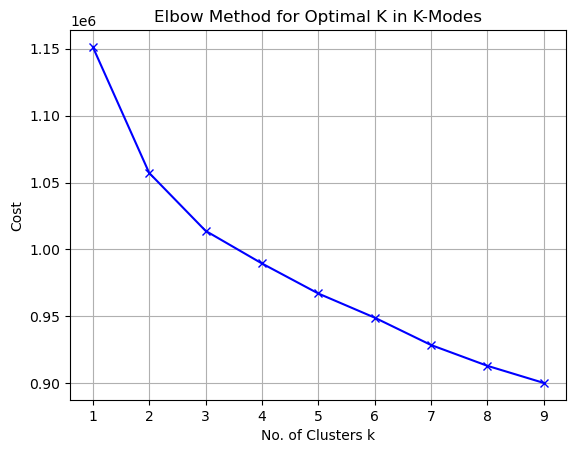

In [13]:
import matplotlib.pyplot as plt
plt.grid('True')
plt.plot(K_red, cost_red, 'bx-')
plt.xlabel('No. of Clusters k')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal K in K-Modes')
plt.show()

Hay posibles codos en K = 2 y K = 3

Mediante Average Silhouette Score podemos saber cuál K es mejor

Primero, se construirá el modelo con 2 clusters

In [14]:
n_clusters = 2
km = KModes(n_clusters=n_clusters, init='Huang', n_init=5, n_jobs=-1, verbose=1)
clusters_2 = km.fit_predict(df_Final)
clusters_2

Best run was number 1


array([0, 1, 1, ..., 0, 1, 0], dtype=uint16)

In [15]:
# Insertemos las etiquetas en nuestro dataset.
df_FCluster2 = df_Final.copy()
df_FCluster2.insert(7,"cluster_labels", clusters_2)
df_FCluster2

,sexo,anio_fall,mes_fall,edad,lugar_ocur,prov_fall,area_fall,cluster_labels
793619,Mujer,2004.0,Noviembre,74.0,Casa,Pichincha,Rural,0
366899,Hombre,1997.0,Septiembre,25.0,Casa,Bolívar,Urbana,1
689408,Hombre,2002.0,Noviembre,16.0,Casa,Pichincha,Urbana,1
474680,Hombre,1999.0,Marzo,3.0,Casa,Guayas,Urbana,1
944418,Hombre,2007.0,Abril,47.0,Casa,Guayas,Urbana,1
...,...,...,...,...,...,...,...,...
1681168,Hombre,2018.0,Diciembre,76.0,Establecimientos del IESS,Santo Domingo de los Tsachilas,Urbana,1
1138052,Hombre,2010.0,Diciembre,39.0,Otro,Manabí,Urbana,1
1647239,Mujer,2018.0,Diciembre,84.0,Establecimientos de la Junta de Beneficiencia,Guayas,Urbana,0
1711899,Hombre,2019.0,Mayo,89.0,Casa,Guayas,Urbana,1


In [16]:
%pip install gower


Note: you may need to restart the kernel to use updated packages.


Se necesita sacar una muestra del dataframe preprocesado, de lo contrario la memoria RAM será insuficiente hasta para entornos de ejecución locales

In [17]:
import gower
from sklearn.metrics import silhouette_score

#Muestra
df_str = df_FCluster2.sample(n=5000, random_state=1)

In [18]:
# Calcular la matriz de distancias de Gower
gower_distances = gower.gower_matrix(df_str.drop('cluster_labels', axis=1))
# Calcular el Silhouette Score
silhouette_avg_gower = silhouette_score(gower_distances, df_str['cluster_labels'], metric='precomputed')
print("Average Categorical Silhouette Score con K = 2:", silhouette_avg_gower)

Average Categorical Silhouette Score con K = 2: 0.12866361


Con K = 3

In [19]:
n_clusters = 3
km = KModes(n_clusters=n_clusters, init='Huang', n_init=5, n_jobs=-1,verbose=1)
clusters_3 = km.fit_predict(df_Final)
clusters_3

Best run was number 5


array([0, 1, 1, ..., 0, 0, 1], dtype=uint16)

In [20]:
# Insertemos las etiquetas en nuestro dataset original.
df_FCluster3 = df_Final.copy()
df_FCluster3.insert(7,"cluster_labels", clusters_3)
df_FCluster3

,sexo,anio_fall,mes_fall,edad,lugar_ocur,prov_fall,area_fall,cluster_labels
793619,Mujer,2004.0,Noviembre,74.0,Casa,Pichincha,Rural,0
366899,Hombre,1997.0,Septiembre,25.0,Casa,Bolívar,Urbana,1
689408,Hombre,2002.0,Noviembre,16.0,Casa,Pichincha,Urbana,1
474680,Hombre,1999.0,Marzo,3.0,Casa,Guayas,Urbana,0
944418,Hombre,2007.0,Abril,47.0,Casa,Guayas,Urbana,0
...,...,...,...,...,...,...,...,...
1681168,Hombre,2018.0,Diciembre,76.0,Establecimientos del IESS,Santo Domingo de los Tsachilas,Urbana,1
1138052,Hombre,2010.0,Diciembre,39.0,Otro,Manabí,Urbana,1
1647239,Mujer,2018.0,Diciembre,84.0,Establecimientos de la Junta de Beneficiencia,Guayas,Urbana,0
1711899,Hombre,2019.0,Mayo,89.0,Casa,Guayas,Urbana,0


In [21]:
#Muestra de nuevo
df_str = df_FCluster3.sample(n=5000, random_state=1)

In [22]:
import gower
from sklearn.metrics import silhouette_score

# Luego calcular la matriz de distancias de Gower como antes
gower_distances = gower.gower_matrix(df_str.drop('cluster_labels', axis=1))
# Calcular el Silhouette Score
silhouette_avg_gower = silhouette_score(gower_distances, df_str['cluster_labels'], metric='precomputed')
print("Average Categorical Silhouette Score con K = 3:", silhouette_avg_gower) 

#Probablemente el print dirá k = 2, ya se corrigió pero no se ejecutó de nuevo por cuestión de tiempo

Average Categorical Silhouette Score con K = 3: 0.06930973


El cluster con K = 2 parece la mejor opción, a pesar de que el número cercano a cero indicará que habrá superposición entre los clusters

## Visualización de los clusters

Antes de visualizar nada, hay que convertir los valores no categóricos del dataframe a valores dummy

In [23]:
df_categorical = pd.get_dummies(df_Final)
df_categorical

,sexo_Hombre,sexo_Mujer,anio_fall_1997.0,anio_fall_1998.0,anio_fall_1999.0,anio_fall_2000.0,anio_fall_2001.0,anio_fall_2002.0,anio_fall_2003.0,anio_fall_2004.0,...,prov_fall_Orellana,prov_fall_Pastaza,prov_fall_Pichincha,prov_fall_Santa Elena,prov_fall_Santo Domingo de los Tsachilas,prov_fall_Sucumbíos,prov_fall_Tungurahua,prov_fall_Zamora Chinchipe,area_fall_Rural,area_fall_Urbana
793619,False,True,False,False,False,False,False,False,False,True,...,False,False,True,False,False,False,False,False,True,False
366899,True,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
689408,True,False,False,False,False,False,False,True,False,False,...,False,False,True,False,False,False,False,False,False,True
474680,True,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
944418,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1681168,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
1138052,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1647239,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1711899,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [24]:
# Reducción de la dimensionalidad
# Instalamaos MCA
%pip install prince

Note: you may need to restart the kernel to use updated packages.


In [25]:
# Importamos la libraría Prince que contiene MCA
import prince
# Indicamos el número de componentes que requerimos, que en este caso es dos.
mca = prince.MCA(n_components=2)
# Ajustamos MCA a nuestros datos
mca = mca.fit(df_categorical)
mca
# Transforme el conjunto de datos (esto le dará las coordenadas de cada muestra en los nuevos ejes)
mca_coordinates = mca.transform(df_categorical)
mca_coordinates

,0,1
793619,0.259746,-0.070368
366899,0.035086,0.111094
689408,-0.001714,0.084482
474680,-0.049203,0.054771
944418,-0.042771,0.063691
...,...,...
1681168,-0.100042,0.077885
1138052,-0.064211,0.175336
1647239,-0.114177,-0.144494
1711899,-0.015784,0.029317


In [26]:
# Agregamos una columna con la etiqueta de los clusters. K = 2
mca_coordinates['cluster_labels'] = df_FCluster2['cluster_labels']
mca_coordinates

,0,1,cluster_labels
793619,0.259746,-0.070368,0
366899,0.035086,0.111094,1
689408,-0.001714,0.084482,1
474680,-0.049203,0.054771,1
944418,-0.042771,0.063691,1
...,...,...,...
1681168,-0.100042,0.077885,1
1138052,-0.064211,0.175336,1
1647239,-0.114177,-0.144494,0
1711899,-0.015784,0.029317,1


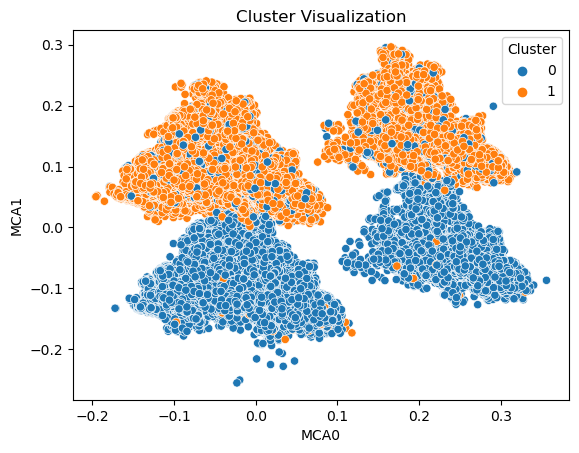

In [27]:
# Dibujamos los clusters
import seaborn as sns
import matplotlib.pyplot as plt

# Dibuja el diagrama de dispersión coloreando los puntos por grupo.

sns.scatterplot(data=mca_coordinates, x=mca_coordinates.iloc[:, 0], y=mca_coordinates.iloc[:, 1], hue='cluster_labels')

# Agregar una leyenda
plt.legend(title='Cluster')

# Optional: Add title and axis labels
plt.title('Cluster Visualization')
plt.xlabel('MCA0')
plt.ylabel('MCA1')

# Show the plot
plt.show()

# Observaciones clase 06 de mayo
## Los comentarios y sugerencias de los profesores sobre la entrega actual dejan varias tareas para la ocasión:
* ### Cambiar random_state para que concuerde con el número del equipo
* ### Modificar, optimizar y probar hiperparámetros según lo mostrado en la misma clase
* ### Seleccionar variables
* * #### Para este caso se probará primero con los dataframes obtenidos para los clusters: df_FCluster2 y df_FCluster3

En primer lugar, random_state se cambió a 4 en una de las celdas de inicio para que la aleatoriedad de la muestra sea el número del equipo

Se volverá a calcular Average Categorical Silhouette Score para los dataframes con 2 y 3 clusters, modificando y añadiendo hiperparámeros hasta llegar a un mínimo de 0.2, o lo más cercano a este

Siguiendo la recomendación del profesor Henry, no se modificarán los hiperparámetros de max_iter y cat_dissim

Para reducir el tiempo de cada prueba, KModes usará todos los procesadores disponibles con el hiperparámetro n_jobs=-1

Se aumentará únicamente n_init a 20

### Para K = 2

In [28]:
n_clusters_tst = 2
km_tst = KModes(n_clusters=n_clusters_tst, init='Huang', n_init=20, n_jobs=-1 ,verbose=1)
clusters_2_tst = km_tst.fit_predict(df_Final)
clusters_2_tst

Best run was number 19


array([1, 0, 0, ..., 1, 0, 0], dtype=uint16)

In [29]:
# Insertemos las etiquetas en nuestro dataset.
df_FCluster2_tst = df_Final.copy()
df_FCluster2_tst.insert(7,"cluster_labels", clusters_2_tst)
df_FCluster2_tst

,sexo,anio_fall,mes_fall,edad,lugar_ocur,prov_fall,area_fall,cluster_labels
793619,Mujer,2004.0,Noviembre,74.0,Casa,Pichincha,Rural,1
366899,Hombre,1997.0,Septiembre,25.0,Casa,Bolívar,Urbana,0
689408,Hombre,2002.0,Noviembre,16.0,Casa,Pichincha,Urbana,0
474680,Hombre,1999.0,Marzo,3.0,Casa,Guayas,Urbana,0
944418,Hombre,2007.0,Abril,47.0,Casa,Guayas,Urbana,0
...,...,...,...,...,...,...,...,...
1681168,Hombre,2018.0,Diciembre,76.0,Establecimientos del IESS,Santo Domingo de los Tsachilas,Urbana,0
1138052,Hombre,2010.0,Diciembre,39.0,Otro,Manabí,Urbana,0
1647239,Mujer,2018.0,Diciembre,84.0,Establecimientos de la Junta de Beneficiencia,Guayas,Urbana,1
1711899,Hombre,2019.0,Mayo,89.0,Casa,Guayas,Urbana,0


In [30]:
#Muestra
df_str_tst = df_FCluster2_tst.sample(n=5000, random_state=1)

In [31]:
# Calcular la matriz de distancias de Gower
gower_distances_tst = gower.gower_matrix(df_str_tst.drop('cluster_labels', axis=1))
# Calcular el Silhouette Score
silhouette_avg_gower_tst = silhouette_score(gower_distances_tst, df_str_tst['cluster_labels'], metric='precomputed')
print("Average Categorical Silhouette Score con K = 2:", silhouette_avg_gower_tst)

Average Categorical Silhouette Score con K = 2: 0.15020148


El ACSS bajó ligeramente, se intentará añadir un valor aleatorio de inicialización

In [32]:
n_clusters_tst = 2
km_tst = KModes(n_clusters=n_clusters_tst, init='Huang', n_init=20, n_jobs=-1, verbose=1, random_state=1)
clusters_2_tst = km_tst.fit_predict(df_Final)
clusters_2_tst

Best run was number 9


array([0, 1, 1, ..., 0, 1, 1], dtype=uint16)

In [33]:
# Insertemos las etiquetas en nuestro dataset.
df_FCluster2_tst = df_Final.copy()
df_FCluster2_tst.insert(7,"cluster_labels", clusters_2_tst)
df_FCluster2_tst

,sexo,anio_fall,mes_fall,edad,lugar_ocur,prov_fall,area_fall,cluster_labels
793619,Mujer,2004.0,Noviembre,74.0,Casa,Pichincha,Rural,0
366899,Hombre,1997.0,Septiembre,25.0,Casa,Bolívar,Urbana,1
689408,Hombre,2002.0,Noviembre,16.0,Casa,Pichincha,Urbana,1
474680,Hombre,1999.0,Marzo,3.0,Casa,Guayas,Urbana,1
944418,Hombre,2007.0,Abril,47.0,Casa,Guayas,Urbana,1
...,...,...,...,...,...,...,...,...
1681168,Hombre,2018.0,Diciembre,76.0,Establecimientos del IESS,Santo Domingo de los Tsachilas,Urbana,1
1138052,Hombre,2010.0,Diciembre,39.0,Otro,Manabí,Urbana,1
1647239,Mujer,2018.0,Diciembre,84.0,Establecimientos de la Junta de Beneficiencia,Guayas,Urbana,0
1711899,Hombre,2019.0,Mayo,89.0,Casa,Guayas,Urbana,1


Adicionalmente, se cambió el random_state de la muestra del dataframe, únicamente para probar si esto cambiaba en algo el ACSS

In [34]:
#Muestra
df_str_tst = df_FCluster2_tst.sample(n=5000, random_state=4)

In [35]:
# Calcular la matriz de distancias de Gower
gower_distances_tst = gower.gower_matrix(df_str_tst.drop('cluster_labels', axis=1))
# Calcular el Silhouette Score
silhouette_avg_gower_tst = silhouette_score(gower_distances_tst, df_str_tst['cluster_labels'], metric='precomputed')
print("Average Categorical Silhouette Score con K = 2:", silhouette_avg_gower_tst)

Average Categorical Silhouette Score con K = 2: 0.14278542


ACSS aumentó ligeramente, se intenta con otro número para el random_state

In [36]:
n_clusters_tst = 2
km_tst = KModes(n_clusters=n_clusters_tst, init='Huang', n_init=20, n_jobs=-1, verbose=1, random_state=2)
clusters_2_tst = km_tst.fit_predict(df_Final)
clusters_2_tst

Best run was number 18


array([0, 1, 1, ..., 0, 1, 1], dtype=uint16)

In [37]:
# Insertemos las etiquetas en nuestro dataset.
df_FCluster2_tst = df_Final.copy()
df_FCluster2_tst.insert(7,"cluster_labels", clusters_2_tst)
df_FCluster2_tst

,sexo,anio_fall,mes_fall,edad,lugar_ocur,prov_fall,area_fall,cluster_labels
793619,Mujer,2004.0,Noviembre,74.0,Casa,Pichincha,Rural,0
366899,Hombre,1997.0,Septiembre,25.0,Casa,Bolívar,Urbana,1
689408,Hombre,2002.0,Noviembre,16.0,Casa,Pichincha,Urbana,1
474680,Hombre,1999.0,Marzo,3.0,Casa,Guayas,Urbana,1
944418,Hombre,2007.0,Abril,47.0,Casa,Guayas,Urbana,1
...,...,...,...,...,...,...,...,...
1681168,Hombre,2018.0,Diciembre,76.0,Establecimientos del IESS,Santo Domingo de los Tsachilas,Urbana,1
1138052,Hombre,2010.0,Diciembre,39.0,Otro,Manabí,Urbana,1
1647239,Mujer,2018.0,Diciembre,84.0,Establecimientos de la Junta de Beneficiencia,Guayas,Urbana,0
1711899,Hombre,2019.0,Mayo,89.0,Casa,Guayas,Urbana,1


In [38]:
#Muestra
df_str_tst = df_FCluster2_tst.sample(n=5000, random_state=4)

In [39]:
# Calcular la matriz de distancias de Gower
gower_distances = gower.gower_matrix(df_str_tst.drop('cluster_labels', axis=1))
# Calcular el Silhouette Score
silhouette_avg_gower_tst = silhouette_score(gower_distances, df_str_tst['cluster_labels'], metric='precomputed')
print("Average Categorical Silhouette Score con K = 2:", silhouette_avg_gower_tst)

Average Categorical Silhouette Score con K = 2: 0.14655532


Viendo la tendencia a aumentar el ACSS conforme aumenta random_state, se prueba con 5

In [40]:
n_clusters_tst = 2
km_tst = KModes(n_clusters=n_clusters_tst, init='Huang', n_init=20, n_jobs=-1, verbose=1, random_state=5)
clusters_2_tst = km_tst.fit_predict(df_Final)
clusters_2_tst

Best run was number 8


array([1, 0, 0, ..., 1, 0, 0], dtype=uint16)

In [41]:
# Insertemos las etiquetas en nuestro dataset.
df_FCluster2_tst = df_Final.copy()
df_FCluster2_tst.insert(7,"cluster_labels", clusters_2_tst)
df_FCluster2_tst

,sexo,anio_fall,mes_fall,edad,lugar_ocur,prov_fall,area_fall,cluster_labels
793619,Mujer,2004.0,Noviembre,74.0,Casa,Pichincha,Rural,1
366899,Hombre,1997.0,Septiembre,25.0,Casa,Bolívar,Urbana,0
689408,Hombre,2002.0,Noviembre,16.0,Casa,Pichincha,Urbana,0
474680,Hombre,1999.0,Marzo,3.0,Casa,Guayas,Urbana,0
944418,Hombre,2007.0,Abril,47.0,Casa,Guayas,Urbana,0
...,...,...,...,...,...,...,...,...
1681168,Hombre,2018.0,Diciembre,76.0,Establecimientos del IESS,Santo Domingo de los Tsachilas,Urbana,0
1138052,Hombre,2010.0,Diciembre,39.0,Otro,Manabí,Urbana,0
1647239,Mujer,2018.0,Diciembre,84.0,Establecimientos de la Junta de Beneficiencia,Guayas,Urbana,1
1711899,Hombre,2019.0,Mayo,89.0,Casa,Guayas,Urbana,0


In [42]:
#Muestra
df_str_tst = df_FCluster2_tst.sample(n=5000, random_state=4)

In [43]:
# Calcular la matriz de distancias de Gower
gower_distances = gower.gower_matrix(df_str_tst.drop('cluster_labels', axis=1))
# Calcular el Silhouette Score
silhouette_avg_gower_tst = silhouette_score(gower_distances, df_str_tst['cluster_labels'], metric='precomputed')
print("Average Categorical Silhouette Score con K = 2:", silhouette_avg_gower_tst)

Average Categorical Silhouette Score con K = 2: 0.17204906


random_state=6

In [44]:
n_clusters_tst = 2
km_tst = KModes(n_clusters=n_clusters_tst, init='Huang', n_init=20, n_jobs=-1, verbose=1, random_state=6)
clusters_2_tst = km_tst.fit_predict(df_Final)
clusters_2_tst

Best run was number 5


array([1, 0, 0, ..., 1, 0, 0], dtype=uint16)

In [45]:
# Insertemos las etiquetas en nuestro dataset.
df_FCluster2_tst = df_Final.copy()
df_FCluster2_tst.insert(7,"cluster_labels", clusters_2_tst)
df_FCluster2_tst

,sexo,anio_fall,mes_fall,edad,lugar_ocur,prov_fall,area_fall,cluster_labels
793619,Mujer,2004.0,Noviembre,74.0,Casa,Pichincha,Rural,1
366899,Hombre,1997.0,Septiembre,25.0,Casa,Bolívar,Urbana,0
689408,Hombre,2002.0,Noviembre,16.0,Casa,Pichincha,Urbana,0
474680,Hombre,1999.0,Marzo,3.0,Casa,Guayas,Urbana,0
944418,Hombre,2007.0,Abril,47.0,Casa,Guayas,Urbana,0
...,...,...,...,...,...,...,...,...
1681168,Hombre,2018.0,Diciembre,76.0,Establecimientos del IESS,Santo Domingo de los Tsachilas,Urbana,0
1138052,Hombre,2010.0,Diciembre,39.0,Otro,Manabí,Urbana,0
1647239,Mujer,2018.0,Diciembre,84.0,Establecimientos de la Junta de Beneficiencia,Guayas,Urbana,1
1711899,Hombre,2019.0,Mayo,89.0,Casa,Guayas,Urbana,0


In [46]:
#Muestra
df_str_tst = df_FCluster2_tst.sample(n=5000, random_state=4)

In [47]:
# Calcular la matriz de distancias de Gower
gower_distances = gower.gower_matrix(df_str_tst.drop('cluster_labels', axis=1))
# Calcular el Silhouette Score
silhouette_avg_gower_tst = silhouette_score(gower_distances, df_str_tst['cluster_labels'], metric='precomputed')
print("Average Categorical Silhouette Score con K = 2:", silhouette_avg_gower_tst)

Average Categorical Silhouette Score con K = 2: 0.13771287


ACSS bajó, se conserva random_state=5

### Para K = 3
Se intenta con random_state=5, 4 y 6 para comprobar si los resultados son como K = 2

In [48]:
n_clusters_tst = 3
km_tst = KModes(n_clusters=n_clusters_tst, init='Huang', n_init=20, n_jobs=-1, random_state=5 , verbose=1)
clusters_3_tst = km_tst.fit_predict(df_Final)
clusters_3_tst

Best run was number 9


array([0, 1, 1, ..., 0, 1, 1], dtype=uint16)

In [49]:
# Insertemos las etiquetas en nuestro dataset original.
df_FCluster3_tst = df_Final.copy()
df_FCluster3_tst.insert(7,"cluster_labels", clusters_3_tst)
df_FCluster3_tst

,sexo,anio_fall,mes_fall,edad,lugar_ocur,prov_fall,area_fall,cluster_labels
793619,Mujer,2004.0,Noviembre,74.0,Casa,Pichincha,Rural,0
366899,Hombre,1997.0,Septiembre,25.0,Casa,Bolívar,Urbana,1
689408,Hombre,2002.0,Noviembre,16.0,Casa,Pichincha,Urbana,1
474680,Hombre,1999.0,Marzo,3.0,Casa,Guayas,Urbana,1
944418,Hombre,2007.0,Abril,47.0,Casa,Guayas,Urbana,1
...,...,...,...,...,...,...,...,...
1681168,Hombre,2018.0,Diciembre,76.0,Establecimientos del IESS,Santo Domingo de los Tsachilas,Urbana,1
1138052,Hombre,2010.0,Diciembre,39.0,Otro,Manabí,Urbana,1
1647239,Mujer,2018.0,Diciembre,84.0,Establecimientos de la Junta de Beneficiencia,Guayas,Urbana,0
1711899,Hombre,2019.0,Mayo,89.0,Casa,Guayas,Urbana,1


In [50]:
#Muestra de nuevo
df_str_tst = df_FCluster3_tst.sample(n=5000, random_state=4)

In [51]:
# Luego calcular la matriz de distancias de Gower como antes
gower_distances_tst = gower.gower_matrix(df_str_tst.drop('cluster_labels', axis=1))
# Calcular el Silhouette Score
silhouette_avg_gower_tst = silhouette_score(gower_distances_tst, df_str_tst['cluster_labels'], metric='precomputed')
print("Average Categorical Silhouette Score con K = 3:", silhouette_avg_gower_tst) 

Average Categorical Silhouette Score con K = 3: 0.10243389


random_state=4

In [52]:
n_clusters_tst = 3
km_tst = KModes(n_clusters=n_clusters_tst, init='Huang', n_init=20, n_jobs=-1, random_state=4 , verbose=1)
clusters_3_tst = km_tst.fit_predict(df_Final)
clusters_3_tst

Best run was number 3


array([0, 2, 1, ..., 0, 2, 1], dtype=uint16)

In [53]:
# Insertemos las etiquetas en nuestro dataset original.
df_FCluster3_tst = df_Final.copy()
df_FCluster3_tst.insert(7,"cluster_labels", clusters_3_tst)
df_FCluster3_tst

,sexo,anio_fall,mes_fall,edad,lugar_ocur,prov_fall,area_fall,cluster_labels
793619,Mujer,2004.0,Noviembre,74.0,Casa,Pichincha,Rural,0
366899,Hombre,1997.0,Septiembre,25.0,Casa,Bolívar,Urbana,2
689408,Hombre,2002.0,Noviembre,16.0,Casa,Pichincha,Urbana,1
474680,Hombre,1999.0,Marzo,3.0,Casa,Guayas,Urbana,2
944418,Hombre,2007.0,Abril,47.0,Casa,Guayas,Urbana,2
...,...,...,...,...,...,...,...,...
1681168,Hombre,2018.0,Diciembre,76.0,Establecimientos del IESS,Santo Domingo de los Tsachilas,Urbana,1
1138052,Hombre,2010.0,Diciembre,39.0,Otro,Manabí,Urbana,1
1647239,Mujer,2018.0,Diciembre,84.0,Establecimientos de la Junta de Beneficiencia,Guayas,Urbana,0
1711899,Hombre,2019.0,Mayo,89.0,Casa,Guayas,Urbana,2


In [54]:
#Muestra de nuevo
df_str_tst = df_FCluster3_tst.sample(n=5000, random_state=4)

In [55]:
# Luego calcular la matriz de distancias de Gower como antes
gower_distances_tst = gower.gower_matrix(df_str_tst.drop('cluster_labels', axis=1))
# Calcular el Silhouette Score
silhouette_avg_gower_tst = silhouette_score(gower_distances_tst, df_str_tst['cluster_labels'], metric='precomputed')
print("Average Categorical Silhouette Score con K = 3:", silhouette_avg_gower_tst) 

Average Categorical Silhouette Score con K = 3: 0.08367186


random_state=6

In [56]:
n_clusters_tst = 3
km_tst = KModes(n_clusters=n_clusters_tst, init='Huang', n_init=20, n_jobs=-1, random_state=6 , verbose=1)
clusters_3_tst = km_tst.fit_predict(df_Final)
clusters_3_tst

Best run was number 15


array([1, 0, 0, ..., 1, 0, 0], dtype=uint16)

In [57]:
# Insertemos las etiquetas en nuestro dataset original.
df_FCluster3_tst = df_Final.copy()
df_FCluster3_tst.insert(7,"cluster_labels", clusters_3_tst)
df_FCluster3_tst

,sexo,anio_fall,mes_fall,edad,lugar_ocur,prov_fall,area_fall,cluster_labels
793619,Mujer,2004.0,Noviembre,74.0,Casa,Pichincha,Rural,1
366899,Hombre,1997.0,Septiembre,25.0,Casa,Bolívar,Urbana,0
689408,Hombre,2002.0,Noviembre,16.0,Casa,Pichincha,Urbana,0
474680,Hombre,1999.0,Marzo,3.0,Casa,Guayas,Urbana,0
944418,Hombre,2007.0,Abril,47.0,Casa,Guayas,Urbana,0
...,...,...,...,...,...,...,...,...
1681168,Hombre,2018.0,Diciembre,76.0,Establecimientos del IESS,Santo Domingo de los Tsachilas,Urbana,0
1138052,Hombre,2010.0,Diciembre,39.0,Otro,Manabí,Urbana,2
1647239,Mujer,2018.0,Diciembre,84.0,Establecimientos de la Junta de Beneficiencia,Guayas,Urbana,1
1711899,Hombre,2019.0,Mayo,89.0,Casa,Guayas,Urbana,0


In [58]:
#Muestra de nuevo
df_str_tst = df_FCluster3_tst.sample(n=5000, random_state=4)

In [59]:
# Luego calcular la matriz de distancias de Gower como antes
gower_distances_tst = gower.gower_matrix(df_str_tst.drop('cluster_labels', axis=1))
# Calcular el Silhouette Score
silhouette_avg_gower_tst = silhouette_score(gower_distances_tst, df_str_tst['cluster_labels'], metric='precomputed')
print("Average Categorical Silhouette Score con K = 3:", silhouette_avg_gower_tst) 

Average Categorical Silhouette Score con K = 3: 0.08701365


El ACSS sigue muy bajo para ser considerado sobre K = 2

In [60]:
n_clusters_tst = 3
km_tst = KModes(n_clusters=n_clusters_tst, init='Huang', n_init=20, n_jobs=-1, verbose=1, random_state=5)
clusters_3_tst = km_tst.fit_predict(df_Final)
clusters_3_tst

Best run was number 9


array([0, 1, 1, ..., 0, 1, 1], dtype=uint16)

In [61]:
# Insertemos las etiquetas en nuestro dataset.
df_FCluster3_tst = df_Final.copy()
df_FCluster3_tst.insert(7,"cluster_labels", clusters_3_tst)
df_FCluster3_tst

,sexo,anio_fall,mes_fall,edad,lugar_ocur,prov_fall,area_fall,cluster_labels
793619,Mujer,2004.0,Noviembre,74.0,Casa,Pichincha,Rural,0
366899,Hombre,1997.0,Septiembre,25.0,Casa,Bolívar,Urbana,1
689408,Hombre,2002.0,Noviembre,16.0,Casa,Pichincha,Urbana,1
474680,Hombre,1999.0,Marzo,3.0,Casa,Guayas,Urbana,1
944418,Hombre,2007.0,Abril,47.0,Casa,Guayas,Urbana,1
...,...,...,...,...,...,...,...,...
1681168,Hombre,2018.0,Diciembre,76.0,Establecimientos del IESS,Santo Domingo de los Tsachilas,Urbana,1
1138052,Hombre,2010.0,Diciembre,39.0,Otro,Manabí,Urbana,1
1647239,Mujer,2018.0,Diciembre,84.0,Establecimientos de la Junta de Beneficiencia,Guayas,Urbana,0
1711899,Hombre,2019.0,Mayo,89.0,Casa,Guayas,Urbana,1


In [62]:
#Muestra
df_str_tst = df_FCluster3_tst.sample(n=5000, random_state=4)

In [63]:
# Calcular la matriz de distancias de Gower
gower_distances = gower.gower_matrix(df_str_tst.drop('cluster_labels', axis=1))
# Calcular el Silhouette Score
silhouette_avg_gower_tst = silhouette_score(gower_distances, df_str_tst['cluster_labels'], metric='precomputed')
print("Average Categorical Silhouette Score con K = 3:", silhouette_avg_gower_tst)

Average Categorical Silhouette Score con K = 3: 0.10243389


## Dado el ACSS obtenido con K = 2 de 0.17, se usará ese KModes para el resto del modelo

In [64]:
n_clusters_tst = 2
km_tst = KModes(n_clusters=n_clusters_tst, init='Huang', n_init=20, n_jobs=-1, verbose=1, random_state=5)
clusters_2_tst = km_tst.fit_predict(df_Final)
# Insertemos las etiquetas en nuestro dataset.
df_FCluster2_tst = df_Final.copy()
df_FCluster2_tst.insert(7,"cluster_labels", clusters_2_tst)
df_FCluster2_tst

Best run was number 8


,sexo,anio_fall,mes_fall,edad,lugar_ocur,prov_fall,area_fall,cluster_labels
793619,Mujer,2004.0,Noviembre,74.0,Casa,Pichincha,Rural,1
366899,Hombre,1997.0,Septiembre,25.0,Casa,Bolívar,Urbana,0
689408,Hombre,2002.0,Noviembre,16.0,Casa,Pichincha,Urbana,0
474680,Hombre,1999.0,Marzo,3.0,Casa,Guayas,Urbana,0
944418,Hombre,2007.0,Abril,47.0,Casa,Guayas,Urbana,0
...,...,...,...,...,...,...,...,...
1681168,Hombre,2018.0,Diciembre,76.0,Establecimientos del IESS,Santo Domingo de los Tsachilas,Urbana,0
1138052,Hombre,2010.0,Diciembre,39.0,Otro,Manabí,Urbana,0
1647239,Mujer,2018.0,Diciembre,84.0,Establecimientos de la Junta de Beneficiencia,Guayas,Urbana,1
1711899,Hombre,2019.0,Mayo,89.0,Casa,Guayas,Urbana,0


In [65]:
df_categorical = pd.get_dummies(df_FCluster2_tst)
df_categorical

,cluster_labels,sexo_Hombre,sexo_Mujer,anio_fall_1997.0,anio_fall_1998.0,anio_fall_1999.0,anio_fall_2000.0,anio_fall_2001.0,anio_fall_2002.0,anio_fall_2003.0,...,prov_fall_Orellana,prov_fall_Pastaza,prov_fall_Pichincha,prov_fall_Santa Elena,prov_fall_Santo Domingo de los Tsachilas,prov_fall_Sucumbíos,prov_fall_Tungurahua,prov_fall_Zamora Chinchipe,area_fall_Rural,area_fall_Urbana
793619,1,False,True,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,True,False
366899,0,True,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
689408,0,True,False,False,False,False,False,False,True,False,...,False,False,True,False,False,False,False,False,False,True
474680,0,True,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
944418,0,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1681168,0,True,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
1138052,0,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1647239,1,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1711899,0,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [66]:
# Indicamos el número de componentes que requerimos
import prince
mca = prince.MCA(n_components=8)
# Ajustamos MCA a nuestros datos
mca = mca.fit(df_FCluster2_tst)
mca
# Transforme el conjunto de datos (esto le dará las coordenadas de cada muestra en los nuevos ejes)
mca_coordinates = mca.transform(df_FCluster2_tst)
mca_coordinates

,0,1,2,3,4,5,6,7
793619,0.619908,-0.638454,-0.137127,-0.182022,-0.181235,-0.244786,-0.017903,-0.118137
366899,-0.540672,-0.567929,-0.477686,-0.030803,0.135644,0.060161,-0.149474,-0.234338
689408,-0.456645,-0.136341,-0.464611,-0.167180,-0.012186,0.007971,0.046640,0.604228
474680,-0.399686,0.244009,-0.174307,-0.504954,-0.035388,-0.053549,-0.411087,0.378713
944418,-0.438715,0.094763,0.253859,-0.340912,0.275495,-0.564770,0.036179,-0.291879
...,...,...,...,...,...,...,...,...
1681168,-0.446577,0.416787,0.680137,0.648891,-0.711904,0.242456,-0.077456,-0.381994
1138052,-0.796658,-0.080799,-0.628331,0.879795,0.298784,-0.242345,0.978962,-0.236059
1647239,0.565252,1.017809,0.345113,-0.260973,1.479272,1.564738,-0.466626,-0.176129
1711899,-0.244267,-0.041428,0.518947,-0.043535,0.087725,0.199976,0.075242,0.316285


In [67]:
# Agregamos una columna con la etiqueta de los clusters. K = 2
mca_coordinates['cluster_labels'] = df_FCluster2_tst['cluster_labels']
mca_coordinates

,0,1,2,3,4,5,6,7,cluster_labels
793619,0.619908,-0.638454,-0.137127,-0.182022,-0.181235,-0.244786,-0.017903,-0.118137,1
366899,-0.540672,-0.567929,-0.477686,-0.030803,0.135644,0.060161,-0.149474,-0.234338,0
689408,-0.456645,-0.136341,-0.464611,-0.167180,-0.012186,0.007971,0.046640,0.604228,0
474680,-0.399686,0.244009,-0.174307,-0.504954,-0.035388,-0.053549,-0.411087,0.378713,0
944418,-0.438715,0.094763,0.253859,-0.340912,0.275495,-0.564770,0.036179,-0.291879,0
...,...,...,...,...,...,...,...,...,...
1681168,-0.446577,0.416787,0.680137,0.648891,-0.711904,0.242456,-0.077456,-0.381994,0
1138052,-0.796658,-0.080799,-0.628331,0.879795,0.298784,-0.242345,0.978962,-0.236059,0
1647239,0.565252,1.017809,0.345113,-0.260973,1.479272,1.564738,-0.466626,-0.176129,1
1711899,-0.244267,-0.041428,0.518947,-0.043535,0.087725,0.199976,0.075242,0.316285,0


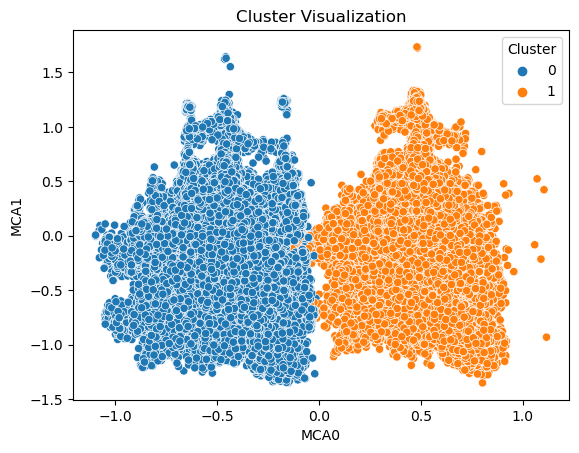

In [68]:
# Dibujamos los clusters
import seaborn as sns
import matplotlib.pyplot as plt

# Dibuja el diagrama de dispersión coloreando los puntos por grupo.

sns.scatterplot(data=mca_coordinates, x=mca_coordinates.iloc[:, 0], y=mca_coordinates.iloc[:, 1], hue='cluster_labels')

# Agregar una leyenda
plt.legend(title='Cluster')

# Optional: Add title and axis labels
plt.title('Cluster Visualization')
plt.xlabel('MCA0')
plt.ylabel('MCA1')

# Show the plot
plt.show()